# Attention Scoring Function
In section 10.2, Gaussian Kernel is used to model the relation between query and key. Exponential part of the Gaussian Kernel could be regarded as attention scoring function. Put the output of that function into softmax will obtain the probability distribution of the key and relevant value, which is also the attention weights. Finally, the output of the attention pooling is the weighted sun of those weights
![average sum](../statics/imgs/section10.3_fig1.jpg)
Distribution of attention weights is probability distribution, so the essence of the weighted sum is weighted average value
Describe in math, assuming there is a query $\mathbf{Q}$ and $m$ *key-value* pairs $(\mathbf{k}_1, \mathbf{v}_1),...,(\mathbf{k}_m, \mathbf{v}_m)$, attention pooling function can be represented as the weighted sum of values:
$$
f(\mathbf{q},(\mathbf{k}_1, \mathbf{v}_1),...,(\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m\alpha(\mathbf{q}, \mathbf{k}_i)\mathbf{v}_i
$$
where the average weights of query $\mathbf{q}$ and key $\mathbf{k}_i$ are mapped to scalar quantity by attention scoring function and softmax:
$$
\alpha(\mathbf{q}, \mathbf{k}_i) = softmax(a(\mathbf{q}, \mathbf{k}_i)) = \frac{exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^mexp(a(\mathbf{q}, \mathbf{k}_i))
$$
where $a$ us attention scoring function

In [1]:
import torch
import math
from torch import nn
from d2l import torch as d2l

In [7]:
def masked_softmax(X, valid_lens):
    """
    some sequences padded with meaningless special tokens so that could be processed effectively in batches in the previous operations. To obtain attention pooling by using only meaningful tokens as values, we could appoint a valid length of sequences so that we could eliminate elements that out of the position when computing softmax.
    :param X: 3D tensor
    :param valid_lens: 1D or 2D tensor
    :return: softmax that only uses the values in the valid part
    """
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # replace the masked elements in the last axis with a very big negative value, which could make its softmax value becomes 0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [8]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4500, 0.5500, 0.0000, 0.0000],
         [0.5652, 0.4348, 0.0000, 0.0000]],

        [[0.2555, 0.2731, 0.4714, 0.0000],
         [0.3008, 0.3736, 0.3255, 0.0000]]])

In [9]:
# using 2-dimensional tensor to appoint valid length for each row in the matrix sample
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3698, 0.3930, 0.2372, 0.0000]],

        [[0.3674, 0.6326, 0.0000, 0.0000],
         [0.2563, 0.2038, 0.3257, 0.2143]]])

## Additive attention
Normally, when query and key are vectors that are in different lengths, we could use additive attention as scoring function. Given query $\mathbf{q}$ and key $\mathbf{k}$, the scoring function of additive attention is
$$
a(\mathbf{q}, \mathbf{k}) = \mathbf{w}^\top_vtanh(\mathbf{W}_q\mathbf{q} + \mathbf{W}_k\mathbf{k})
$$
where the $Ws$ are learnable parameters. Query and key will be concatenated and put into an MLP, which contains one hidden layerand uses tanh as activation function

In [12]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # queries: (batch_size, len(queries), 1, num_hidden)
        # key: (batch_size, 1, len(k-v), num_hidden)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)  # score: (batch_size, len(queries), len(k-v))
        self.attention_weights = masked_softmax(scores, valid_lens)  # attention weights of the scoring function
        # values: (batch_size, len(k-v), len(value.shape))
        return torch.bmm(self.dropout(self.attention_weights), values)  # attention

In [13]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

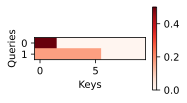

In [14]:
# although additive attention contains learnable parameters, we use the same keys in this case, so the weights are symmetrical as well.
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

## Scaled dot-product attention scoring function
using dot-product could gain scoring function which is more effective, but the dot-product operation requires quires and keys have the same length. Assuming the length is d, in order to make the variance of product is always 1 regardless of the effects of length, we scoring function is:
$$
a(\mathbf{q}, \mathbf{k}) = \frac{\mathbf{q}^\top\mathbf{k}}{\sqrt{d}}
$$
In practice, we always use small batches to improve effectiveness, such as based on $n$ quires and $m$ key-value pairs. The scaled dot-product attention of $\mathbf{Q} \in \mathbf{R}^{n \times d}, \mathbf{K} \in \mathbf{R}^{m \times d} and \mathbf{V} \in \mathbf{R}^{m \times v}$ is
$$
softmax(\frac{\mathbf{q}^\top\mathbf{k}}{\sqrt{d}})\mathbf{V} \in \mathbf{R}^{n\times v}
$$

In [17]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [18]:
quries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(quries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

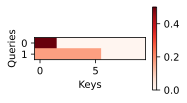

In [19]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')